#  Importing libraries 

In [1]:
import pandas as pd 
import numpy as np 
import os 

C:\Users\Hassan Kerroumi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
for dirname, _, filenames in os.walk('Garbage_Classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# reading and processing data 
import cv2
import urllib 
import itertools 
import seaborn as sns 
import os, random, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen 

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

# model evaluation 
from sklearn.metrics import confusion_matrix, classification_report 

# modeling 

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

#  Reading the dataset 

In [4]:
dir_path = 'C:/Users/M S I/Pattern-Recognition - Copy/data/Garbage_Classification/Garbage classification'

In [47]:
target_size = (224, 224)
waste_labels = {'cardboard':0, 'glass':1, 'metal':2, 'paper':3, 'plastic':4, 'trash':5}

In [48]:
def load_dataset(path):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(waste_labels[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return np.array(x), np.array(labels) 


In [49]:
x, labels = load_dataset(dir_path)

X size : (2527, 224, 224, 3)
Number of label classes [0 1 2 3 4 5], Number of observation in the dataset : 2527


In [50]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[0], 3)
print(input_shape)

(224, 224, 3)


In [51]:
np.array(list(list(waste_labels.keys())))

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# Sample from dataset

In [52]:
def visualize_img(image_batch, label_batch,n):
    """  Parameters:



  image_batch: Storing the matrix information of the images



  label_batch: A list that stores the class information of the image

    """
    plt.figure(figsize=(15,65))
    j = 0
    for n in range(100+n):
        ax = plt.subplot(20,5,j+1)
        j +=1
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys())) [to_categorical(labels, num_classes=6)[n]==1][0].title())

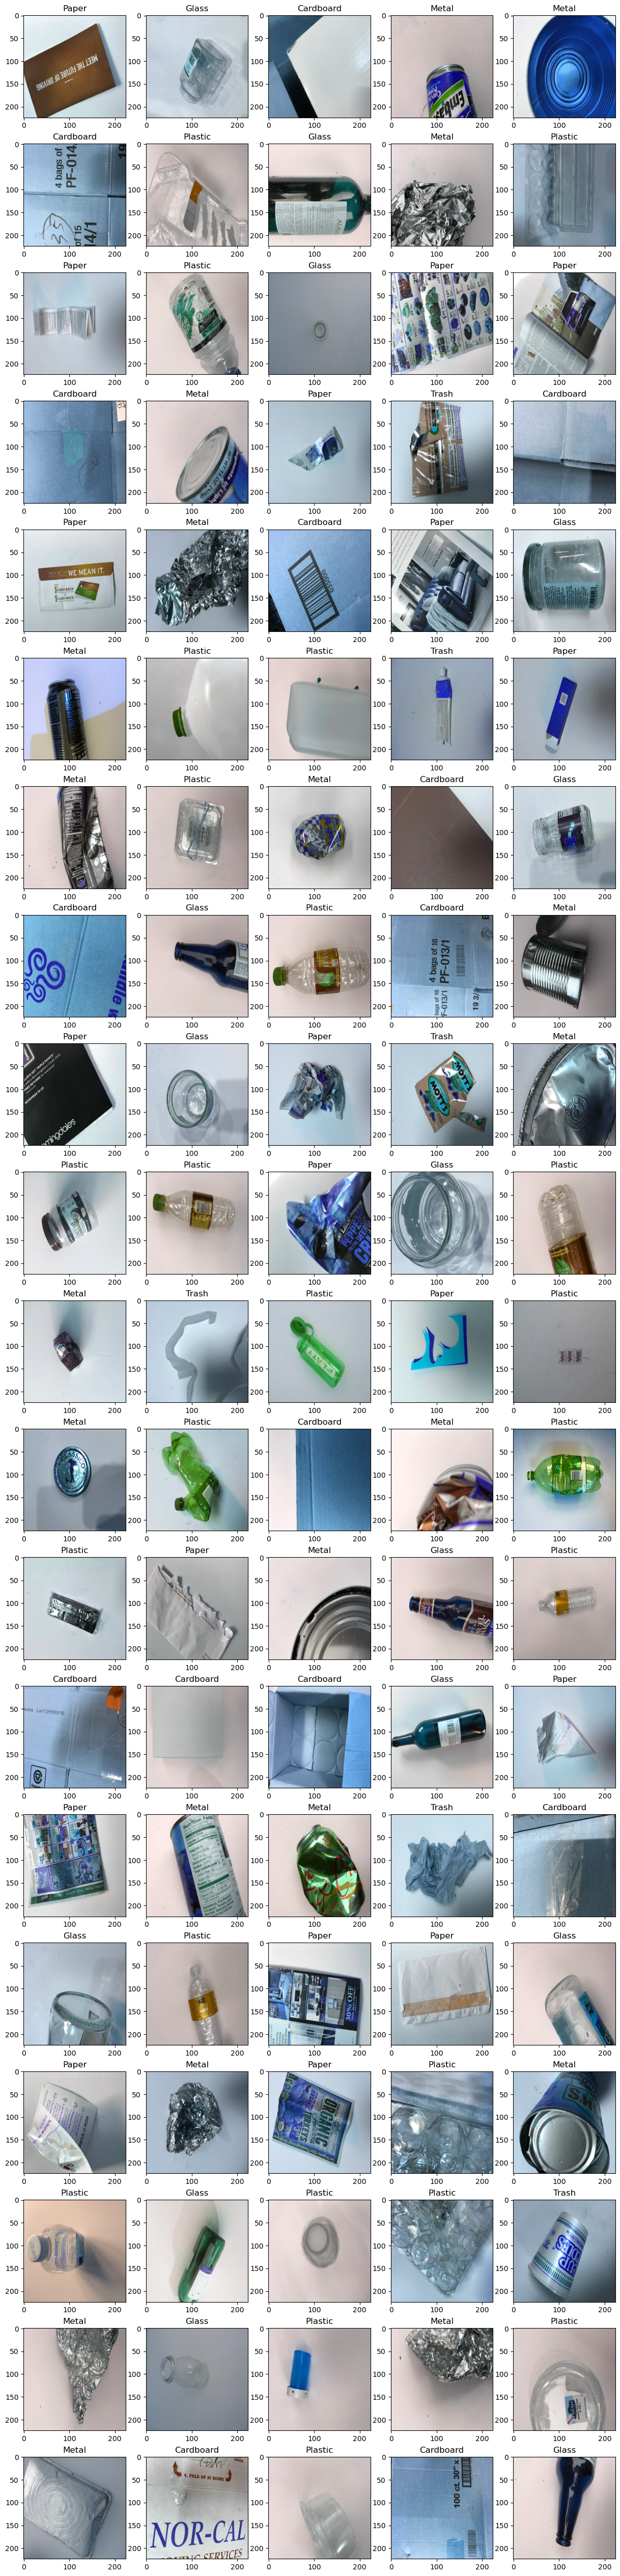

In [53]:
visualize_img(x, labels,0)

In [54]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, labels, test_size = 0.2, random_state = 42)

# Modeling
- Create a CNN model 

# with 1000 features 

In [55]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input

resnet = ResNet50(weights='imagenet', include_top=True)

In [56]:
xtrain_features = resnet.predict(xtrain)
xtest_features = resnet.predict(xtest)

print("Feature vector shape:", xtrain_features.shape)


64/64 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Feature vector shape: (2021, 1000)


# KNN model

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Variables d'entrée
k = 3  # Nombre de voisins
knn_model = KNeighborsClassifier(n_neighbors=k)

# Entraîner le modèle
knn_model.fit(xtrain_features, ytrain)

# Prédictions sur les données de test
y_pred = knn_model.predict(xtest_features)

# Évaluer la précision du modèle
accuracy = accuracy_score(ytest, y_pred)
print(f'Précision du modèle KNN : {accuracy}')


Précision du modèle KNN : 0.5810276679841897


In [68]:
y_proba = knn_model.predict_proba(xtest_features)

In [69]:
y_pred.shape,ytest.shape

((506,), (506,))

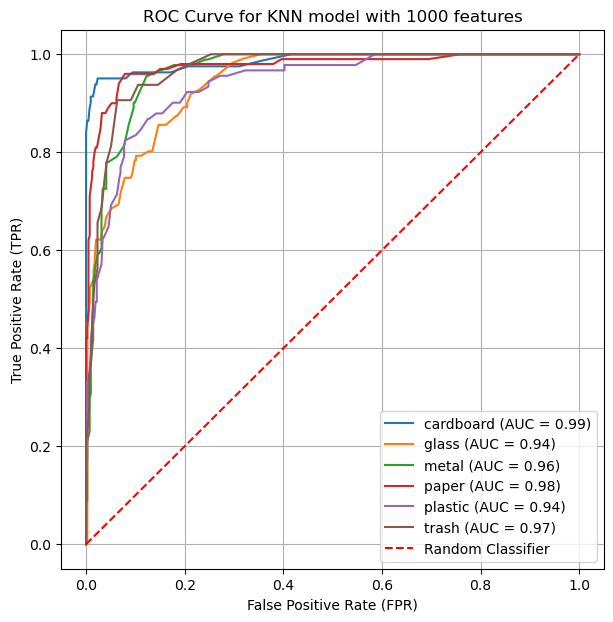

In [95]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
n_classes = 6
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(ytest, classes=np.arange(n_classes))

# Initialize plots
plt.figure(figsize=(7, 7))

# ROC Curve
for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve for KNN model with 1000 features')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

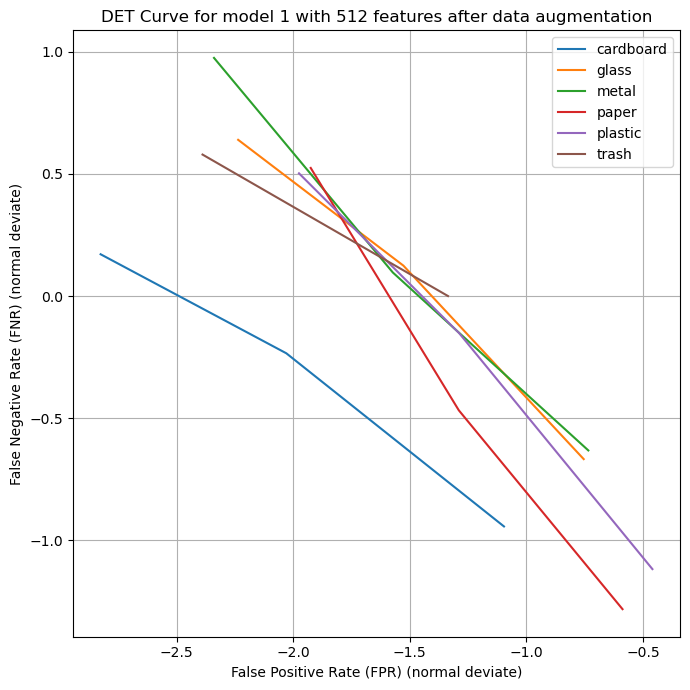

In [80]:
from scipy.stats import norm
# DET Curve
plt.figure(figsize=(7, 7))
for i in range(n_classes):
    # Compute ROC curve (to get FPR and TPR)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    fnr = 1 - tpr  # Compute False Negative Rate

    # Transform FPR and FNR to normal deviates
    fpr_norm = norm.ppf(fpr)
    fnr_norm = norm.ppf(fnr)

    # Handle invalid values (due to ppf on 0 or 1)
    fpr_norm[np.isinf(fpr_norm)] = np.nan
    fnr_norm[np.isinf(fnr_norm)] = np.nan

    plt.plot(fpr_norm, fnr_norm, label=labels[i])

plt.title('DET Curve for KNN model with 1000 features after data augmentation')
plt.xlabel('False Positive Rate (FPR) (normal deviate)')
plt.ylabel('False Negative Rate (FNR) (normal deviate)')
plt.grid(which='both')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variables d'entrée
n_estimators = 100  # Nombre d'arbres
rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Entraîner le modèle
rf_model.fit(xtrain_features, ytrain)

# Prédictions sur les données de test
y_pred = rf_model.predict(xtest_features)

# Évaluer la précision du modèle
accuracy = accuracy_score(ytest, y_pred)
print(f'Précision du modèle Random Forest : {accuracy}')


Précision du modèle Random Forest : 0.7628458498023716


In [75]:
y_proba1 = rf_model.predict_proba(xtest_features)

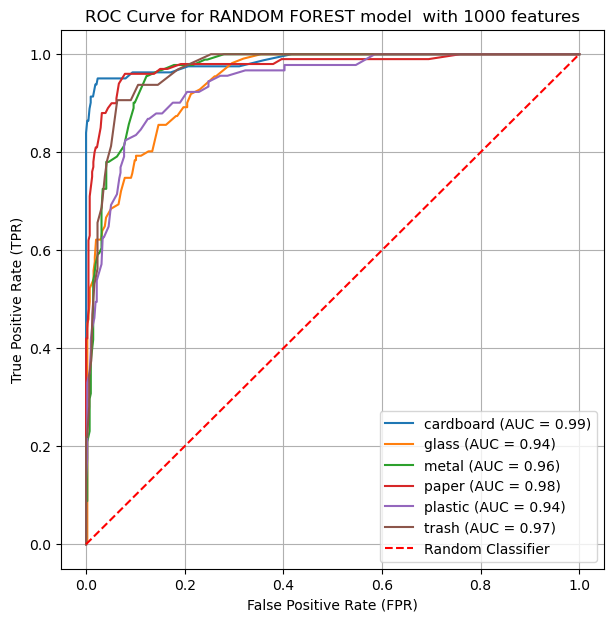

In [97]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
n_classes = 6
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(ytest, classes=np.arange(n_classes))

# Initialize plots
plt.figure(figsize=(7, 7))

# ROC Curve
for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba1[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], y_proba1[:, i])
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve for RANDOM FOREST model  with 1000 features')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

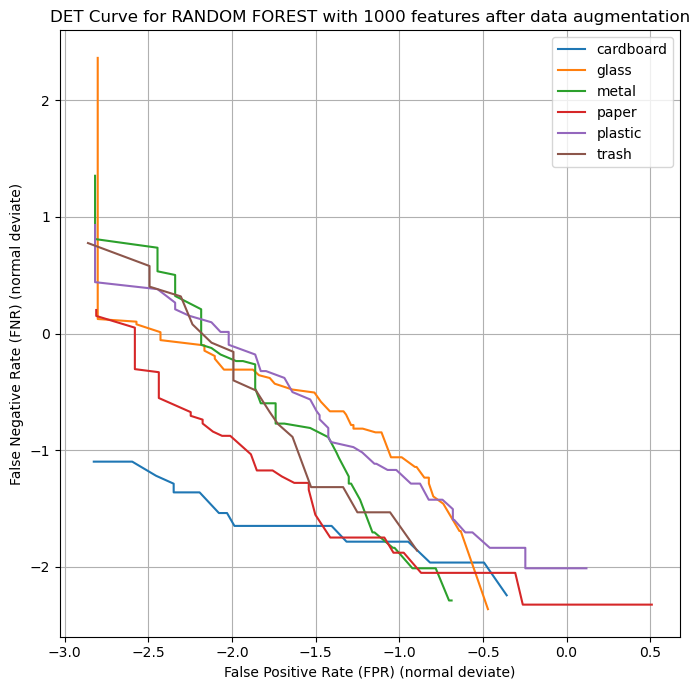

In [101]:
from scipy.stats import norm
# DET Curve
plt.figure(figsize=(7, 7))
for i in range(n_classes):
    # Compute ROC curve (to get FPR and TPR)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba1[:, i])
    fnr = 1 - tpr  # Compute False Negative Rate

    # Transform FPR and FNR to normal deviates
    fpr_norm = norm.ppf(fpr)
    fnr_norm = norm.ppf(fnr)

    # Handle invalid values (due to ppf on 0 or 1)
    fpr_norm[np.isinf(fpr_norm)] = np.nan
    fnr_norm[np.isinf(fnr_norm)] = np.nan

    plt.plot(fpr_norm, fnr_norm, label=labels[i])

plt.title('DET Curve for RANDOM FOREST with 1000 features after data augmentation')
plt.xlabel('False Positive Rate (FPR) (normal deviate)')
plt.ylabel('False Negative Rate (FNR) (normal deviate)')
plt.grid(which='both')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# with 512 features 

In [82]:
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [83]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
VGG_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
x = VGG_model.output  # Shape: (7, 7, 512)
x = GlobalAveragePooling2D()(x)  # Shape: (512,)
VGG16_model = Model(inputs=VGG_model.input, outputs=x)

In [85]:
Xtrain_features = VGG16_model.predict(xtrain)
Xtest_features = VGG16_model.predict(xtest)

64/64 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step


In [86]:
Xtrain_features.shape

(2021, 512)

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Variables d'entrée
k = 3  # Nombre de voisins
knn_model = KNeighborsClassifier(n_neighbors=k)

# Entraîner le modèle
knn_model.fit(Xtrain_features, ytrain)

# Prédictions sur les données de test
y_pred = knn_model.predict(Xtest_features)

# Évaluer la précision du modèle
accuracy = accuracy_score(ytest, y_pred)
print(f'Précision du modèle KNN : {accuracy}')


Précision du modèle KNN : 0.8043478260869565


In [89]:
y_proba = rf_model.predict_proba(Xtest_features)

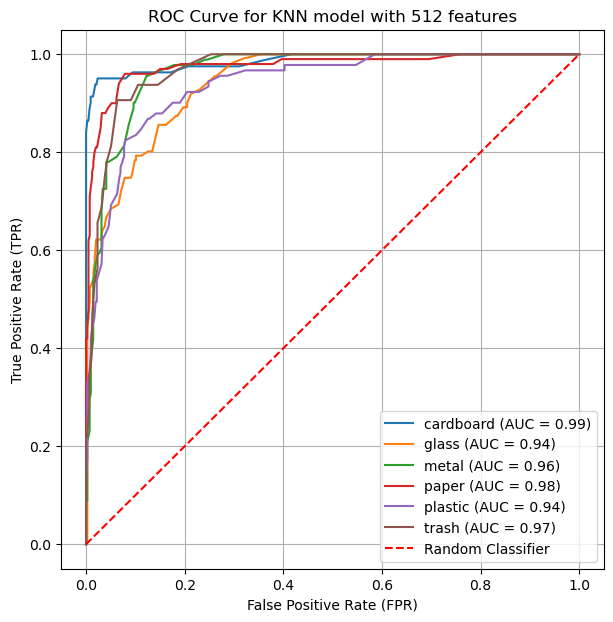

In [90]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
n_classes = 6
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(ytest, classes=np.arange(n_classes))

# Initialize plots
plt.figure(figsize=(7, 7))

# ROC Curve
for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve for KNN model with 512 features')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

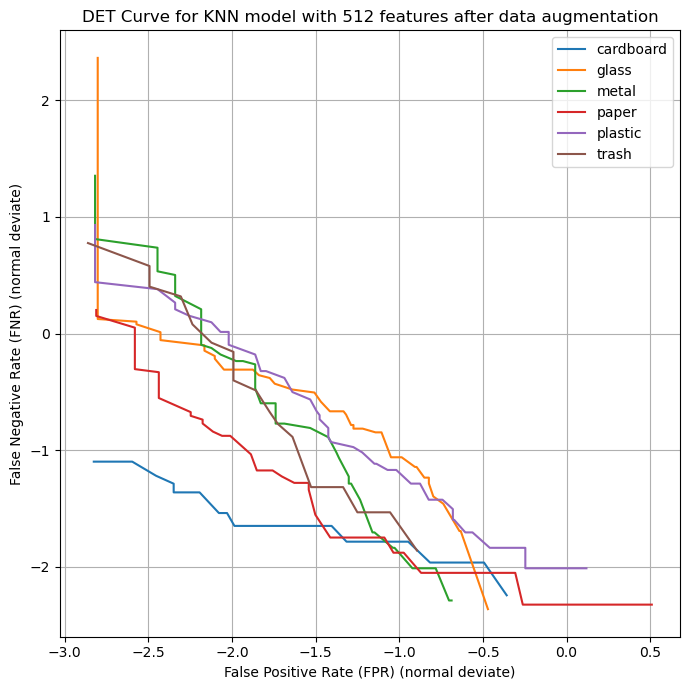

In [96]:
from scipy.stats import norm
# DET Curve
plt.figure(figsize=(7, 7))
for i in range(n_classes):
    # Compute ROC curve (to get FPR and TPR)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    fnr = 1 - tpr  # Compute False Negative Rate

    # Transform FPR and FNR to normal deviates
    fpr_norm = norm.ppf(fpr)
    fnr_norm = norm.ppf(fnr)

    # Handle invalid values (due to ppf on 0 or 1)
    fpr_norm[np.isinf(fpr_norm)] = np.nan
    fnr_norm[np.isinf(fnr_norm)] = np.nan

    plt.plot(fpr_norm, fnr_norm, label=labels[i])

plt.title('DET Curve for KNN model with 512 features after data augmentation')
plt.xlabel('False Positive Rate (FPR) (normal deviate)')
plt.ylabel('False Negative Rate (FNR) (normal deviate)')
plt.grid(which='both')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variables d'entrée
n_estimators = 100  # Nombre d'arbres
rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Entraîner le modèle
rf_model.fit(Xtrain_features, ytrain)

# Prédictions sur les données de test
y_pred = rf_model.predict(Xtest_features)

# Évaluer la précision du modèle
accuracy = accuracy_score(ytest, y_pred)
print(f'Précision du modèle Random Forest : {accuracy}')


Précision du modèle Random Forest : 0.7924901185770751


In [104]:
y_proba1 = rf_model.predict_proba(Xtest_features)

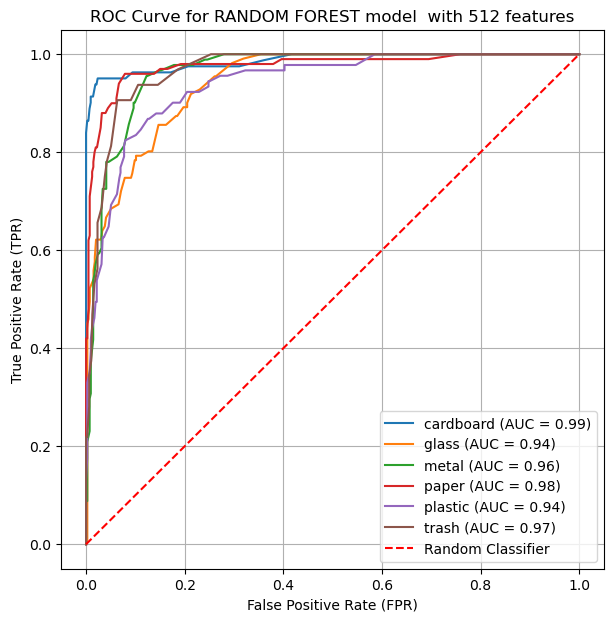

In [105]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
n_classes = 6
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(ytest, classes=np.arange(n_classes))

# Initialize plots
plt.figure(figsize=(7, 7))

# ROC Curve
for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba1[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], y_proba1[:, i])
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve for RANDOM FOREST model  with 512 features')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

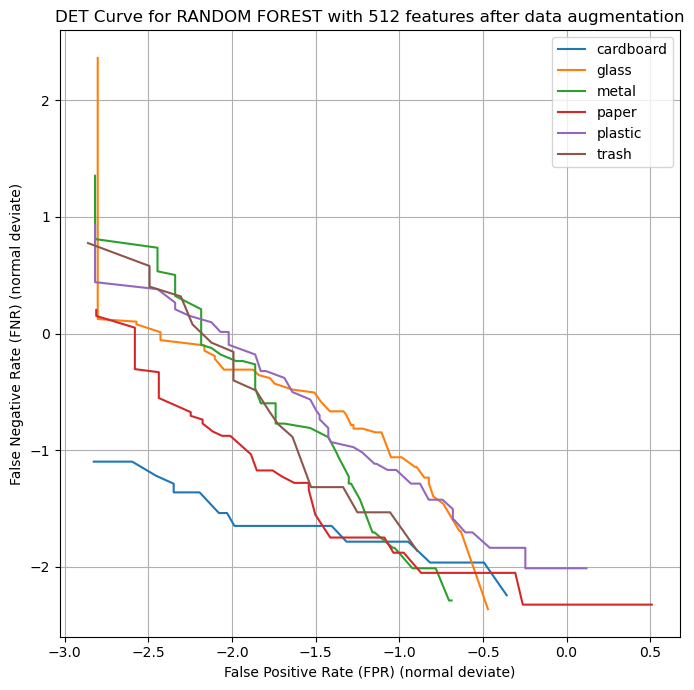

In [106]:
from scipy.stats import norm
# DET Curve
plt.figure(figsize=(7, 7))
for i in range(n_classes):
    # Compute ROC curve (to get FPR and TPR)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba1[:, i])
    fnr = 1 - tpr  # Compute False Negative Rate

    # Transform FPR and FNR to normal deviates
    fpr_norm = norm.ppf(fpr)
    fnr_norm = norm.ppf(fnr)

    # Handle invalid values (due to ppf on 0 or 1)
    fpr_norm[np.isinf(fpr_norm)] = np.nan
    fnr_norm[np.isinf(fnr_norm)] = np.nan

    plt.plot(fpr_norm, fnr_norm, label=labels[i])

plt.title('DET Curve for RANDOM FOREST with 512 features after data augmentation')
plt.xlabel('False Positive Rate (FPR) (normal deviate)')
plt.ylabel('False Negative Rate (FNR) (normal deviate)')
plt.grid(which='both')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()